# **Inscribed square problem with Xpress NonLinear and Xpress Global**

***inscribed_square.ipynb***

This example shows how to use FICO&reg; Xpress NonLinear (SLP) or FICO&reg; Xpress Global to solve an instance of the inscribed square problem.

<!--*This example requires a license for the FICO&reg; Xpress Global solver. Click on [this link](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) for more information about trial and licensing options.*-->

&copy; Copyright 2025 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://community.fico.com/s/contentdocument/06980000002h0i5AAA) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the xpress package
%pip install -q xpress

The inscribed square problem, also known as the square peg problem or the Toeplitz' conjecture, is an unsolved question in geometry: Does every plane simple closed curve contain all four vertices of some square? The problem was proposed by [Otto Toeplitz in 1911](https://en.wikipedia.org/wiki/Inscribed_square_problem).
The next example is a special instance of the problem, and computes a **maximal inscribing square** for the curve defined by: 

$$(\sin(t)*\cos(t), \sin(t)*t), t \in [-\pi,\pi]$$

[Source in MINLPLIB](https://www.minlplib.org/inscribedsquare01.html)

The problem is formulated using decision variables $x_i, \forall i = 1..8$. The first four variables range between $[-\pi,\pi]$, corresponding to the four values of the parameter $t$. Then, $x_5$ and $x_6$ are the (x,y) coordinates of the first corner of the square, while ($x_7, x_8$) is a vector pointing to a second vertex. The remaining vertices are given by a combination of $x_5..x_8$. The length of the vector ($x_7, x_8$) is exactly the side length of the square, which we aim at maximizing.

The first two constraints define $x_5$ and $x_6$ as the coordinates of the first point:
$$
\begin{align*}
& \qquad \sin(x_1) * \cos(x_1) = x_5 \\
& \qquad \sin(x_1) * x_1 = x_6 \\
\end{align*}
$$

The next two constraints define $x_7$ and $x_8$ as the pointed vector from the first to the second point:
$$
\begin{align*}
& \qquad \sin(x_2) * \cos(x_2) = x_5 + x_7\\
& \qquad \sin(x_2) * x_2 = x_6 + x_8 \\
\end{align*}
$$

The remaining four constraints make sure that we define a square by comparing vectors between the remaining points:
$$
\begin{align*}
& \qquad \sin(x_3) * \cos(x_3) = x_5 - x_8 \\
& \qquad \sin(x_3) * x_3 = x_6 + x_7 \\
& \qquad \sin(x_4) * \cos(x_4) = x_5 + x_7 - x_8 \\
& \qquad \sin(x_4) * x_4 = x_6 + x_7 + x_8 \\
\end{align*}
$$

The objective is to maximize the length of one (or each) side of the square:
$$
\begin{align*}
& \qquad \max x_7^2 + x_8^2
\end{align*}
$$


<!--The method [problem.nlpsetinitval](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.nlpsetinitval.html) sets the initial value of a nonlinear variable to ...-->


In [4]:
import xpress as xp
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from collections import namedtuple

p = xp.problem()

# Add the variables, note that we force the (x7, x8) vector to have positive components to break symmetry.
x1 = p.addVariable(name="x1", lb=-math.pi, ub=math.pi) # x1..x4 are the four values of the parameter t.
x2 = p.addVariable(name="x2", lb=-math.pi, ub=math.pi)
x3 = p.addVariable(name="x3", lb=-math.pi, ub=math.pi)
x4 = p.addVariable(name="x4", lb=-math.pi, ub=math.pi)
x5 = p.addVariable(name="x5")                          #  x5 and x6 are the (x,y) coordinates of the first corner of the square.
x6 = p.addVariable(name="x6")
x7 = p.addVariable(name="x7", lb=0)                    # (x7, x8) is a vector pointing to a second vertex, all the other vertices are given by a combination of x5..x8.
x8 = p.addVariable(name="x8", lb=0)                    

# set initial values for the local solvers
p.nlpsetinitval([x1, x2, x4, x5, x6, x7, x8], [-math.pi, -math.pi/2, math.pi/2, 0, 0, 1, 1])

# the first two constraints define x5 and x6 as the coordinates of the first point
p.addConstraint(xp.sin(x1) * xp.cos(x1) == x5)
p.addConstraint(xp.sin(x1) * x1         == x6)
# the next two constraints define x7 and x8 as the pointed vector from the first to the second point
p.addConstraint(xp.sin(x2) * xp.cos(x2) == x5 + x7)
p.addConstraint(xp.sin(x2) * x2         == x6 + x8)
# the remaining four constraints make sure that we define a square by comparing vectors between the remaining points
p.addConstraint(xp.sin(x3) * xp.cos(x3) == x5 - x8)
p.addConstraint(xp.sin(x3) * x3         == x6 + x7)
p.addConstraint(xp.sin(x4) * xp.cos(x4) == x5 + x7 - x8)
p.addConstraint(xp.sin(x4) * x4         == x6 + x7 + x8)

# the objective is to maximize the length of one (or each) side of the square
p.setObjective(x7**2 + x8**2,sense=xp.maximize)

# choose between solving with a local or global solver
p.controls.nlpsolver = 2                       # 1: local, 2: global, -1: solver decides based on license and user functions / multistart jobs (default)
# choose between solving with SLP or Knitro
p.controls.localsolver = 0                     # 0: SLP, 1: Knitro, 2: use Optimizer (for convex QPs only), -1: automatic selection based on model characteristics and solver availability (default)

p.optimize()


Original problem size
   linear:    8 rows, 8 columns, 16 linear coefficients
   quadratic: 2 in obj, 0 rows, 0 in rows
   nonlinear: 8 coefficients, 40 tokens
              4 mul             0 div         0 sqrt
              8 sin             4 cos         0 tan
Nonlinear presolve
   converted quadratic objective into an SLP constraint
   simplify removed 4 tokens
   bound tightening reduced 4 bounds
   objective transfer row R9 through variable C10
Presolved problem size
   linear:    9 rows, 10 columns, 17 linear coefficients
   nonlinear: 9 coefficients, 47 tokens
              4 mul             0 div         0 sqrt
              0 exp             0 log         2 pow
              8 sin             4 cos         0 tan
Problem is nonlinear presolved
FICO Xpress v9.5.1, Community, solve started 16:40:42, Jan 30, 2025
Control settings used:
OUTPUTLOG = 1
LOCALSOLVER = 0
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
NLPSOLVER = 2
XSLP_OBJSENSE = -1
Maximum expanded nl-formula size: 7  (ro

   1          .324373     4.000000      1      0     74   91.89%       8      0
 
Cuts in the matrix         : 14
Cut elements in the matrix : 35

Starting tree search.
Deterministic mode with up to 20 running threads and up to 64 tasks.
Heap usage: 2794KB (peak 2941KB, 560KB system)
 
    Node     BestSoln    BestBound   Sols Active  Depth     Gap     GInf   Time
       1      .324373     4.000000      1      2      1   91.89%       8      0
       2      .324373     4.000000      1      2      2   91.89%       9      0
       3      .324373     4.000000      1      2      2   91.89%       9      0
       4      .324373     4.000000      1      2      3   91.89%       9      0
       5      .324373     4.000000      1      2      3   91.89%       7      0
       6      .324373     4.000000      1      2      4   91.89%       9      0
       7      .324373     4.000000      1      5      4   91.89%       8      0
       8      .324373     4.000000      1      8      5   91.89%       9 

(<SolveStatus.COMPLETED: 3>, <SolStatus.OPTIMAL: 1>)

The specific nonlinear solver can be chosen using the [NLPSOLVER](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/nonlinear/HTML/XSLP_NLPSOLVER.html) control:
  - Setting a value of "1" will invoke a local solver, with it being either SLP or Knitro (if a license is available). 
  - The control defaults to -1, which has Xpress choose the most appropriate solver. If there are user functions or multi-start jobs, or if there is no license available for Xpress Global, a local solver will be called. In all other cases, Xpress Global will be used to solve the problem.

If a local solve is invoked, the [LOCALSOLVER](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/nonlinear/HTML/XSLP_SOLVER.html) control specify if either SLP or Knitro should be used by setting the control to "1" or "2" respectively. For convex QPs, setting the value to "2" will set Xpress Optimizer to solve the problem. By default (-1), an automatic selection is made based on model characteristics and solver availability.

By running the previous code cell below with the NLPSOLVER control equal to 1, SLP or Knitro will be called and the problem is solved to local optimality. This can be confirmed by running the code cell again with NLPSOLVER equal to 2, which finds a larger (maximal) square.


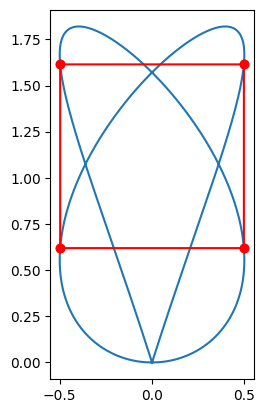

solution: x1: 0.8352856266829147 , x2: -2.406095264212018 , x3: -0.8352893121725296 , x4: 2.40609307228132 , x5: 0.4975142383990962 , x6: 0.6193583260187784 , x7: 8.97332667504358e-07 , x8: 0.9950272339257181


In [2]:
# Visualize solution
Point = namedtuple('Point', 'x y')

def get_coords(t):

  x = np.sin(t) * np.cos(t)
  y = np.sin(t) * t
  return Point(x, y)

# below code approximates the graph of the function
t = np.arange(-math.pi, math.pi, 0.01)
xs = np.sin(t) * np.cos(t)
ys = np.sin(t) * t

# compute the x- and y-coordinates of the four vertices of the square
v1 = get_coords(p.getSolution(x1))
v2 = get_coords(p.getSolution(x2))
v3 = get_coords(p.getSolution(x3))
v4 = get_coords(p.getSolution(x4))

# plot the graph and the square
fig, ax = plt.subplots()
cells = ax.plot(xs, ys)
plt.plot([v1.x, v2.x], [v1.y, v2.y], 'ro-')
plt.plot([v2.x, v4.x], [v2.y, v4.y], 'ro-')
plt.plot([v4.x, v3.x], [v4.y, v3.y], 'ro-')
plt.plot([v3.x, v1.x], [v3.y, v1.y], 'ro-')

ax.set_aspect('equal', adjustable='box')

plt.show()

#print the variable values
print('solution: x1:', p.getSolution(x1), ', x2:', p.getSolution(x2), ', x3:', p.getSolution(x3), ', x4:', p.getSolution(x4), ', x5:', p.getSolution(x5), ', x6:', p.getSolution(x6), ', x7:', p.getSolution(x7), ', x8:', p.getSolution(x8))